<a href="https://colab.research.google.com/github/CKoschenz/Face_Recognition_Project/blob/main/Jupyter_Notebooks/Advanced_Modelling/Face_Recognition_EfficientNetV2M_PIN_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition Project
# Model `EfficientNetV2M`

For Overview of EfficientNetV2 Models see
https://keras.io/api/applications/efficientnet_v2/#efficientnetv2m-function

In [ ]:
!nvidia-smi

Mon Nov 27 18:17:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications

import PIL

import zipfile
import os

## The Dataset

Dataset is the [Pinterest Data Set](https://www.kaggle.com/datasets/hereisburak/pins-face-recognition) from which we selected 10 Identities.

## Import the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/Face_Recognition_Data_Sets/Pins_Face_Recognition_10ID_Selection.zip -d /content/DataSets/

In [ ]:
data_directory = os.path.join(os.getcwd(), 'DataSets/Pins_Face_Recognition_10ID_Selection/')
print(data_directory)

/content/DataSets/Pins_Face_Recognition_10ID_Selection/


In [ ]:
image_size = (160, 160)
batch_size = 64 #64, 128

In [ ]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1671 files belonging to 10 classes.
Using 1337 files for training.
Using 334 files for validation.


In [ ]:
print("Data set classes:\n", train_ds.class_names)

Data set classes:
 ['pins_Adriana Lima', 'pins_Chris Hemsworth', 'pins_Dwayne Johnson', 'pins_Henry Cavil', 'pins_Jason Momoa', 'pins_Morgan Freeman', 'pins_Rihanna', 'pins_Shakira Isabel Mebarak', 'pins_Zoe Saldana', 'pins_scarlett johansson']


In [ ]:
num_classes = 10

@tf.function
def count_class(counts, batch):
    y, _, c = tf.unique_with_counts(batch[1])
    return tf.tensor_scatter_nd_add(counts, tf.expand_dims(y, axis=1), c)

counts = val_ds.reduce(
    initial_state=tf.zeros(num_classes, tf.int32),
    reduce_func=count_class)

print(counts.numpy())

[35 39 33 41 33 20 25 31 38 39]


## Visualize Data
Here are the first 9 images in the training dataset.

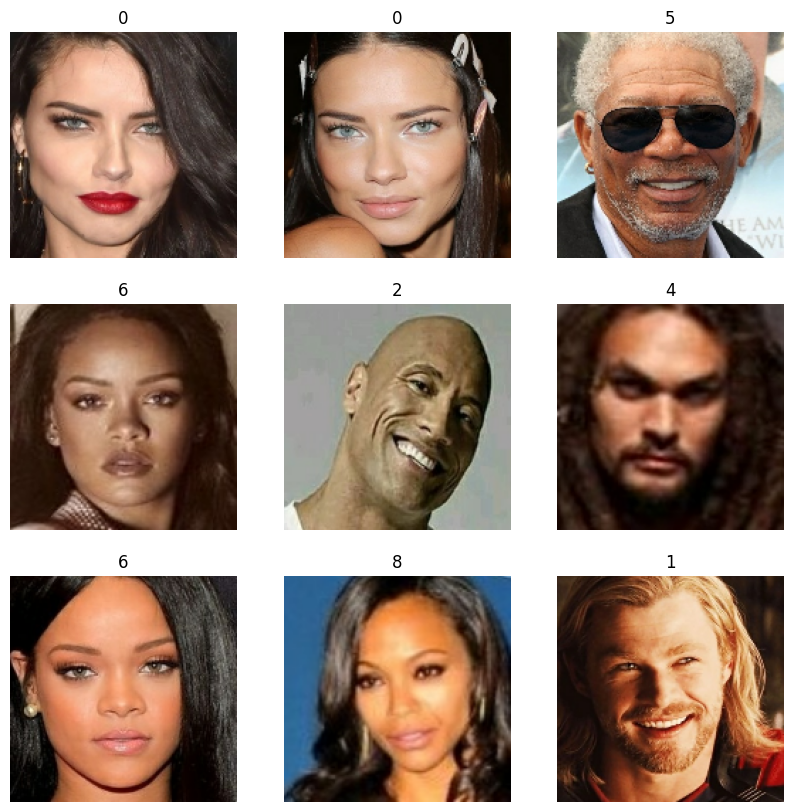

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Image Data Augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

### Defintion of Contrast and Brightness Distortion

In [ ]:
class RandomColorDistortion(tf.keras.layers.Layer):
  def __init__(self, contrast_range=[0.75, 1.25],
               brightness_delta=[-0.1, 0.1], **kwargs):
    super(RandomColorDistortion, self).__init__(**kwargs)
    self.contrast_range = contrast_range
    self.brightness_delta = brightness_delta

  def call(self, images, training=False):
    if not training:
      return images
    contrast = np.random.uniform(
    self.contrast_range[0], self.contrast_range[1])
    brightness = np.random.uniform(
    self.brightness_delta[0], self.brightness_delta[1])

    images = tf.image.adjust_contrast(images, contrast)
    images = tf.image.adjust_brightness(images, brightness)
    images = tf.clip_by_value(images, 0, 255)
    return images

### Definition of Data Augmentation Layer

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
        RandomColorDistortion(name='random_contrast_brightness/none'),
    ],
    name='augmentation_layer')

### Visualization of Augmented Samples
applying data_augmentation repeatedly to the first image in the dataset.

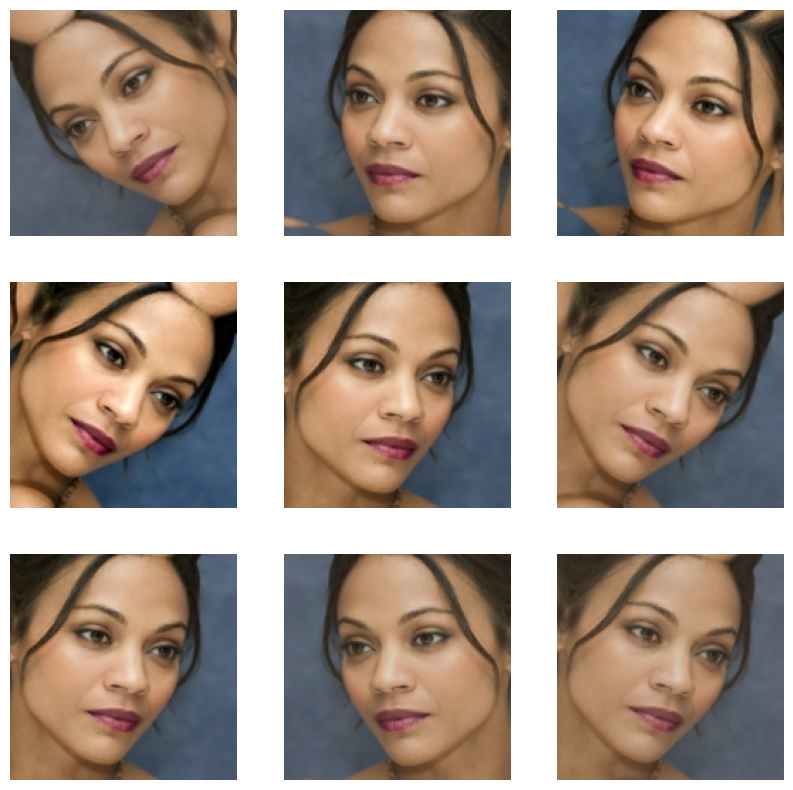

In [ ]:
plt.figure(figsize=(10, 10))

for image, _ in train_ds.take(1):
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')

## Preprocessing Inputs

Preprocessing include in the model, see https://keras.io/api/applications/efficientnet_v2/#efficientnetv2m-function

_Note: each Keras Application expects a specific kind of input preprocessing. For EfficientNetV2, by default input preprocessing is included as a part of the model (as a Rescaling layer), and thus `tf.keras.applications.efficientnet_v2.preprocess_input` is actually a pass-through function. In this use case, EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [0-255] range. At the same time, preprocessing as a part of the model (i.e. Rescaling layer) can be disabled by setting include_preprocessing argument to False. With preprocessing disabled EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [-1, 1] range._


## EfficientNetV2M Base Model

In [ ]:
from tensorflow.keras.applications import EfficientNetV2M

In [ ]:
base_model = EfficientNetV2M(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=image_size + (3,),
                pooling=None,
                classifier_activation="softmax",
                include_preprocessing=True,
            )


In [ ]:
base_model.summary()

Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 160, 160, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 80, 80, 24)           648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 80, 80, 24)           96        ['stem_conv[0][0]']           
 n)                                                                                

## Fine Tuning

### Unfreezing Layer in Pre-Trained Models

In [ ]:
# for layer in base_model.layers:
#     if layer.name == 'LayerName':
#         layer.trainable = True

### Initialization of the Weights
see https://keras.io/api/layers/initializers/

In [ ]:
init = tf.keras.initializers.HeUniform(seed=3710) # GlorotUniform() is also a good choice, feel free to explore
for w in base_model.trainable_variables:
    w.assign(init(w.shape))

## Assemble Model Layers

In [ ]:
pooling_layer = tf.keras.layers.GlobalMaxPooling2D()

inputs = tf.keras.Input(shape=image_size + (3,))
x = data_augmentation(inputs)
#x = preprocess_input(inputs) # included in the base model
x = base_model(x)
x = pooling_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', name='embeddings')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = layers.Dense(len(train_ds.class_names), activation=tf.keras.activations.softmax)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 augmentation_layer (Sequen  (None, 160, 160, 3)       0         
 tial)                                                           
                                                                 
 efficientnetv2-m (Function  (None, 5, 5, 1280)        53150388  
 al)                                                             
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                             

In [ ]:
for layer in model.layers:
  print(layer.name)

input_4
augmentation_layer
efficientnetv2-m
global_max_pooling2d_1
embeddings
dense_1


## Compile Model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Create Callbacks
stop training when target goal is reached

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_accuracy']
        acc = logs['accuracy']
        if val_acc >= 0.9 and np.abs(val_acc-acc)<0.04:
            self.model.stop_training = True
            print("goal reached\n")
        print('\n')
        print("End epoch {} of training\n".format(epoch))
        print('-------------------------------------------')

## Train the Model

In [ ]:
epochs=30
customCallback = CustomCallback()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[customCallback]
)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.2916 - accuracy: 0.1279

End epoch 0 of training

-------------------------------------------
21/21 [==============================] - 144s 1s/step - loss: 2.2916 - accuracy: 0.1279 - val_loss: 2.3958 - val_accuracy: 0.1257
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 2.2581 - accuracy: 0.1488

End epoch 1 of training

-------------------------------------------
21/21 [==============================] - 20s 926ms/step - loss: 2.2581 - accuracy: 0.1488 - val_loss: 14.0157 - val_accuracy: 0.1198
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 2.2100 - accuracy: 0.1720

End epoch 2 of training

-------------------------------------------
21/21 [==============================] - 20s 925ms/step - loss: 2.2100 - accuracy: 0.1720 - val_loss: 4.3480 - val_accuracy: 0.1617
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 2.1841 - accuracy: 0.1713

End epoch 3 of tra

## Save the Model

In [ ]:
model_folder = 'path_to_model'

In [ ]:
model.save(model_folder)

In [ ]:
!tar -czvf resnest50_val_92.tar resnet50_val_0.92

## Save the Weights

In [ ]:
# Save the weights after training
from google.colab import drive
drive.mount('/content/drive')

#weights_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_128_160x160_yes_yes.h5'

model.save_weights(weights_path)

In [ ]:
!tar -czvf weights.tar weights/

## Export History

In [ ]:
csv_path = '/content/drive/My Drive/Face_Recognition_Save/EfficientNetV2M_PIN_Dataset_Batch64_w_dropout.csv'

pd.DataFrame(history.history).to_csv(csv_path)

## Visualize History

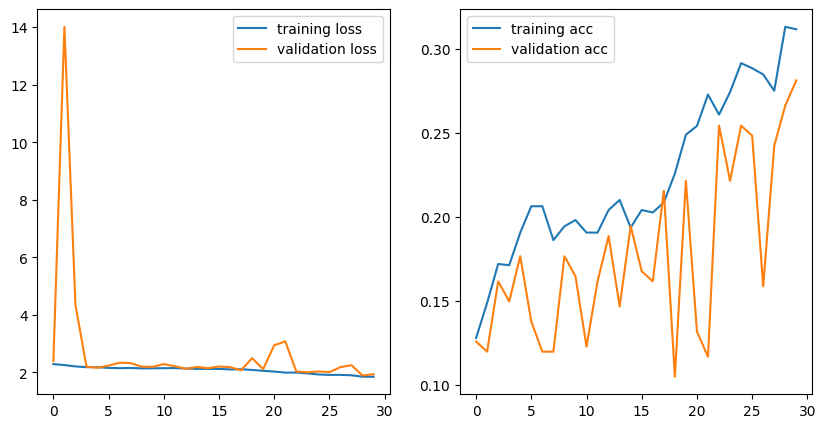

In [ ]:
import matplotlib.pyplot as plt

training_loss, training_acc = history.history['loss'], history.history['accuracy']
val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(training_loss, label='training loss')
ax[0].plot(val_loss, label='validation loss')
ax[0].legend()

ax[1].plot(training_acc, label='training acc')
ax[1].plot(val_acc, label='validation acc')
ax[1].legend()

## Load the Model

In [ ]:
!gdown <path>

zsh:1: command not found: gdown


In [ ]:
!tar -xf resnest50_val_92.tar

In [ ]:
model = keras.saving.load_model('modelfolder')

In [ ]:
for layer in model.layers:
  print(layer.name)

input_11
augmentation_layer
tf.__operators__.getitem_3
tf.nn.bias_add_3
resnet50
global_average_pooling2d_2
embeddings
dense_6


## Load the Weights
- download via `!gdown`
- unzip/tar via `!tar -xf weights.tar`

In [ ]:
model.load_weights('./path_to_weights')

NameError: name 'model' is not defined

## Evaluate Model Performance

### Training Set

In [ ]:
model.evaluate(train_ds)

21/21 [==============================] - 5s 221ms/step - loss: 1.9053 - accuracy: 0.2775


[1.9052892923355103, 0.2774869203567505]

### Validation Set

In [ ]:
model.evaluate(val_ds)

6/6 [==============================] - 2s 220ms/step - loss: 1.9395 - accuracy: 0.2814


[1.9395110607147217, 0.28143712878227234]

### Test Data

In [ ]:
img = tf.keras.utils.load_img(
    'geralt.jpeg', target_size=target_shape
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = preprocess_input(img_array)
img_array.shape

In [ ]:
import PIL

plt.imshow(PIL.Image.open('geralt.jpeg'));

predictions = model(img_array, training=False)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)